In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import h5py
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import G2Net2022Dataset
from tqdm.notebook import tqdm

from transforms import *
import albumentations as A

In [3]:
# from architectures import *
# model = ClassificationModel(
#     classification_model='swin_base_patch4_window12_384',
#     in_chans=2,
#     num_classes=1,
#     custom_preprocess='chris_debias',
#     custom_classifier='avg',
# )
# model = SegmentationAndClassification(
#     segmentation_model='timm-efficientnet-b0',
#     classification_model='tf_efficientnet_b0_ns',
#     in_chans=2,
#     num_classes=1,
#     custom_preprocess='chris_debias',
#     custom_classifier='avg',
#     return_mask=True
# )

# model(torch.empty((2, 2, 352, 640)))[1].shape

In [4]:
df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
df = df.loc[df['target'] != -1]

torch.Size([3, 360, 512])


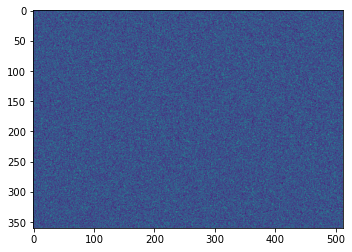

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from transforms import *

ds = G2Net2022Dataset(
    test, 
    data_dir=Path('input/g2net-detecting-continuous-gravitational-waves/test'), 
    # match_time=True,
    spec_diff=True,
    resize_factor=8, 
    transforms=A.Compose([
        # A.Resize(360, 1024), 
        ShiftImage(x_max=100, y_max=100, p=1.0),
        RandomCrop(512),
        ToTensorV2(), 
        # FrequencyMaskingTensor(p=1.0), 
        # TimeMaskingTensor(128, p=1.0),
        # FrequencyMaskingTensor(p=1.0),
        ]),
    normalize='laeyoung')
for i in range(20):
    data = ds[i][0]
    print(data.shape)
    # plt.imshow(data.permute(1,2,0)[:, :1000])
    plt.imshow(ds[i][0][0, :, :1000])
    plt.show()
    break

# Get metadata

In [5]:
# signal_summary = []
# ds = G2Net2022Dataset(df, resize_factor=4, )
# for idx in tqdm(range(len(df))):
#     try:
#         spec_h1, spec_l1 = ds[idx][0]
#     except:
#         print(f'ERROR: {idx}')
#         continue
#     signal_summary.append({
#         'idx': idx,
#         'h1_mean': spec_h1.mean().item(),
#         'h1_max': spec_h1.max().item(),
#         'h1_min': spec_h1.min().item(),
#         'l1_mean': spec_l1.mean().item(),
#         'l1_max': spec_l1.max().item(),
#         'l1_min': spec_l1.min().item()
#     })
# signal_summary = pd.DataFrame(signal_summary)


In [6]:
# signal_summary.describe()

In [5]:
def count_gaps(timestamps, Tsft=1800):
    gap_length = timestamps[1:] - (timestamps[:-1] + Tsft)
    return (gap_length > 0).sum()

In [94]:
signal_summary = []
for gid in tqdm(df['id'].values[:100]):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/train/{gid}.pickle')
    # with h5py.File(fname, 'r') as f:
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        freq = list(f[gid]['frequency_Hz'])
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
        ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
        signal_summary.append({
            'idx': gid,
            'ts_start_h1': ts_start_h1,
            'ts_end_h1': ts_end_h1,
            'num_gaps_h1': count_gaps(time_h1),
            'length_h1': len(time_h1),
            'max_h1': np.max(sig_h1),
            '90%_h1': np.percentile(sig_h1, 90),
            '25%_h1': np.percentile(sig_h1, 25),
            '10%_h1': np.percentile(sig_h1, 10),
            'ts_start_l1': ts_start_l1,
            'ts_end_l1': ts_end_l1,
            'num_gaps_l1': count_gaps(time_l1),
            'length_l1': len(time_l1),
            'max_l1': np.max(sig_l1),
            '90%_l1': np.percentile(sig_l1, 90),
            '25%_l1': np.percentile(sig_l1, 25),
            '10%_l1': np.percentile(sig_l1, 10),
        })
signal_summary = pd.DataFrame(signal_summary)
signal_summary.describe()

In [17]:
signal_summary = []
data_df = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v9.csv').sample(200)
for gid in tqdm(data_df['id'].values):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/v9/{gid}.pickle')
    # with h5py.File(fname, 'r') as f:
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        freq = list(f[gid]['frequency_Hz'])
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
        ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
        signal_summary.append({
            'idx': gid,
            'ts_start_h1': ts_start_h1,
            'ts_end_h1': ts_end_h1,
            'num_gaps_h1': count_gaps(time_h1),
            'length_h1': len(time_h1),
            'max_h1': np.max(sig_h1),
            '90%_h1': np.percentile(sig_h1, 90),
            '25%_h1': np.percentile(sig_h1, 25),
            '10%_h1': np.percentile(sig_h1, 10),
            'ts_start_l1': ts_start_l1,
            'ts_end_l1': ts_end_l1,
            'num_gaps_l1': count_gaps(time_l1),
            'length_l1': len(time_l1),
            'max_l1': np.max(sig_l1),
            '90%_l1': np.percentile(sig_l1, 90),
            '25%_l1': np.percentile(sig_l1, 25),
            '10%_l1': np.percentile(sig_l1, 10),
        })
signal_summary = pd.DataFrame(signal_summary)
signal_summary.describe()

  0%|          | 0/200 [00:00<?, ?it/s]

,ts_start_h1,ts_end_h1,num_gaps_h1,length_h1,max_h1,90%_h1,25%_h1,10%_h1,ts_start_l1,ts_end_l1,num_gaps_l1,length_l1,max_l1,90%_l1,25%_l1,10%_l1
count,2.000000e+02,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,2.000000e+02,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.238172e+09,1.248554e+09,307.135000,4585.820000,34.345959,5.185409,0.647685,0.237246,1.238173e+09,1.248555e+09,308.730000,4577.095000,34.214527,5.184874,0.647732,0.237282
std,6.540451e+03,2.289734e+04,15.031517,81.343478,4.870415,0.010730,0.001080,0.000631,7.464319e+03,2.287507e+04,14.874588,76.768895,5.917054,0.009487,0.001182,0.000638
min,1.238166e+09,1.248512e+09,272.000000,4382.000000,28.431526,5.161019,0.645012,0.235253,1.238166e+09,1.248502e+09,265.000000,4383.000000,28.003899,5.165280,0.644853,0.235551
25%,1.238168e+09,1.248539e+09,297.000000,4536.000000,31.557202,5.179626,0.647013,0.236830,1.238168e+09,1.248538e+09,299.000000,4524.750000,31.435245,5.179456,0.646960,0.236883
50%,1.238170e+09,1.248549e+09,306.000000,4584.500000,33.512100,5.183370,0.647723,0.237268,1.238171e+09,1.248549e+09,309.500000,4574.500000,32.990204,5.183290,0.647742,0.237332
75%,1.238174e+09,1.248565e+09,317.000000,4636.000000,35.670977,5.188011,0.648391,0.237628,1.238176e+09,1.248566e+09,319.000000,4630.000000,35.059322,5.187784,0.648361,0.237736
max,1.238202e+09,1.248649e+09,345.000000,4802.000000,72.962090,5.249333,0.651245,0.239736,1.238217e+09,1.248641e+09,346.000000,4852.000000,86.596695,5.239271,0.652471,0.239394


In [93]:
signal_summary = []
for gid in tqdm(test['id']):
    fname = Path(f'input/g2net-detecting-continuous-gravitational-waves/test/{gid}.pickle')
    # with h5py.File(fname, 'r') as f:
    with open(fname, 'rb') as fp:
        f = pickle.load(fp)
        freq = list(f[gid]['frequency_Hz'])
        sig_h1, time_h1 = f[gid]['H1']['SFTs']*1e22, np.array(f[gid]['H1']['timestamps_GPS'])
        sig_l1, time_l1 = f[gid]['L1']['SFTs']*1e22, np.array(f[gid]['L1']['timestamps_GPS'])
        sig_h1 = sig_h1.real ** 2 + sig_h1.imag ** 2
        sig_l1 = sig_l1.real ** 2 + sig_l1.imag ** 2
        ts_start_h1, ts_end_h1 = time_h1[0], time_h1[-1]
        ts_start_l1, ts_end_l1 = time_l1[0], time_l1[-1]
        signal_summary.append({
            'idx': gid,
            'ts_start_h1': ts_start_h1,
            'ts_end_h1': ts_end_h1,
            'num_gaps_h1': count_gaps(time_h1),
            'length_h1': len(time_h1),
            'max_h1': np.max(sig_h1),
            '90%_h1': np.percentile(sig_h1, 90),
            '25%_h1': np.percentile(sig_h1, 25),
            '10%_h1': np.percentile(sig_h1, 10),
            'ts_start_l1': ts_start_l1,
            'ts_end_l1': ts_end_l1,
            'num_gaps_l1': count_gaps(time_l1),
            'length_l1': len(time_l1),
            'max_l1': np.max(sig_l1),
            '90%_l1': np.percentile(sig_l1, 90),
            '25%_l1': np.percentile(sig_l1, 25),
            '10%_l1': np.percentile(sig_l1, 10),
        })
signal_summary = pd.DataFrame(signal_summary)
signal_summary.describe()

In [8]:
signal_summary.to_csv('input/signal_summary.csv', index=False)

In [6]:
signal_summary = pd.read_csv('input/signal_summary.csv')
test = pd.concat([test, signal_summary.drop('idx', axis=1)], axis=1)
test.to_csv('input/test_metadata.csv', index=False)

In [112]:
test.query('max_h1 < 60').sort_values('max_h1')

,id,target,ts_start_h1,ts_end_h1,num_gaps_h1,length_h1,max_h1,90%_h1,25%_h1,10%_h1,ts_start_l1,ts_end_l1,num_gaps_l1,length_l1,max_l1,90%_l1,25%_l1,10%_l1
301,0a2e0807c,0.5,1238170661,1248560798,315,4444,27.155708,5.193616,0.648482,0.237670,1238172517,1248544775,304,4727,31.831987,5.191594,0.647812,0.236889
2924,5e0075954,0.5,1238167849,1248546074,293,4529,27.507837,5.182478,0.647354,0.237027,1238171716,1248547474,300,4628,38.751175,5.182705,0.646806,0.237185
2176,45938c4f5,0.5,1238168050,1248533794,268,4752,27.600027,5.188679,0.647329,0.236507,1238182190,1248542809,294,4526,30.539581,5.182175,0.646983,0.238255
138,03dddf828,0.5,1238177646,1248546836,329,4581,27.733364,5.181180,0.648240,0.237757,1238176400,1248577673,294,4605,32.489426,5.175855,0.646475,0.236834
5045,a2a379a91,0.5,1238179394,1248542235,302,4562,27.779581,5.185834,0.647151,0.236552,1238167978,1248536845,283,4684,32.336845,5.174686,0.646737,0.237105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2126,441248002,0.5,1238167992,1248537550,338,4514,59.488136,8.555619,1.048718,0.384621,1238175570,1248537924,290,4648,40.239952,5.846144,0.726934,0.266724
7175,e5f7c1840,0.5,1238176496,1248559231,315,4574,59.509400,5.710221,0.698666,0.256469,1238176731,1248532361,288,4636,31.741478,4.680979,0.580917,0.212064
2836,5b10b1e61,0.5,1238169105,1248558400,328,4538,59.605915,8.132969,1.009554,0.368941,1238175497,1248583239,305,4697,37.802956,6.459987,0.802029,0.293465
3621,745ad3f49,0.5,1238172575,1248543953,313,4513,59.617702,8.884781,1.099710,0.403636,1238181628,1248602185,286,4583,42.355600,6.584819,0.817633,0.298464


/home/acb10673fd/.pyenv/versions/anaconda3-2020.02/envs/g2net2022/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

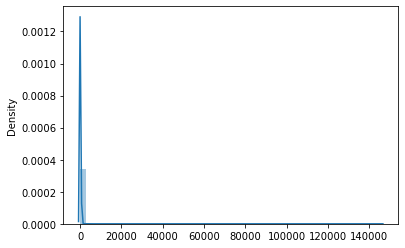

In [14]:
sns.distplot(signal_summary['max_h1'].values)

# Wave generation

In [134]:
import math
import pyfstat
from pyfstat.utils import get_sft_as_arrays
from transforms import adaptive_resize
import shutil
from prep_data_v18v import NoPrint, bucketize_real_noise_asd, TEST_DIR, C_SQRSX

DATASET = 'v18v'

C_SQRSX = 26.6
REF_SX = 5e-24
F1_MIN, F1_MAX = -12, -8 # new sampling
DP_MIN, DP_MID, DP_MAX = 20, 35, 50
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')


def to_spectrogram(sfts):
    return sfts.real ** 2 + sfts.imag ** 2


def extract_artifact(spec):
    spec_std = spec.std()
    spec_min = spec.min()
    amp_map = (spec - spec_min) / spec_std
    artifact_map = amp_map > 10
    return artifact_map


def mix_artifact(sft1, sft2, artifact_map):
    assert sft2.shape == artifact_map.shape
    assert sft2.shape[0] == sft1.shape[0]
    if sft2.shape[1] > sft1.shape[1]:
        artifact_map = artifact_map[:, :sft1.shape[1]]
        sft2 = sft2[:, :sft1.shape[1]]
        sft1[artifact_map] = sft2[artifact_map]
    else:
        sft1[np.where(artifact_map)] = sft2[np.where(artifact_map)]
    return sft1
 

def make_data(gid, num_buckets=128, target='negative'):
    PROJ_DIR = Path(f'input/g2net-detecting-continuous-gravitational-waves/template_{num_buckets}/{gid}')
    PROJ_DIR.mkdir(parents=True, exist_ok=True)
    TMP_DIR = Path(f'pyfstat_tmp_{DATASET}/{gid}/')
    # load test data
    with open(TEST_DIR/f'{gid}.pickle', 'rb') as f:
        test = pickle.load(f)
        sft_h1, ts_h1 = test[gid]['H1']['SFTs'], test[gid]['H1']['timestamps_GPS']
        sft_l1, ts_l1 = test[gid]['L1']['SFTs'], test[gid]['L1']['timestamps_GPS']
        freqs = test[gid]['frequency_Hz']

    artifact_h1 = extract_artifact(to_spectrogram(sft_h1*1e22))
    artifact_l1 = extract_artifact(to_spectrogram(sft_l1*1e22))

    asd_h1, bs_h1 = bucketize_real_noise_asd(sft_h1, ts_h1, num_buckets)
    asd_l1, bs_l1 = bucketize_real_noise_asd(sft_l1, ts_l1, num_buckets)
    
    with NoPrint():
        noise_kwargs_h1 = {
            "outdir": str(TMP_DIR),
            "Tsft": 1800,
            "F0": np.mean(freqs),
            # "F0": freqs[0],
            "detectors": "H1",
            "SFTWindowType": "tukey",
            "SFTWindowBeta": 0.1,
            "Band": 0.4,
            "duration": bs_h1,
        }
        if (PROJ_DIR/'sft_list_h1.csv').exists():
            sft_paths_h1 = pd.read_csv(PROJ_DIR/'sft_list_h1.csv')['path'].tolist()
        else:
            tmp_paths = []
            sft_paths_h1 = []
            for segment in range(num_buckets):
                args = noise_kwargs_h1.copy()
                args["label"] = f"h1_segment_{segment}"
                args["sqrtSX"] = asd_h1[segment] / C_SQRSX
                args["tstart"] = ts_h1[0] + segment * bs_h1
                writer = pyfstat.Writer(**args)
                writer.make_data()
                tmp_paths.append(writer.sftfilepath)
            for path in tmp_paths:
                shutil.move(Path(path), PROJ_DIR)
                sft_paths_h1.append(str(PROJ_DIR/Path(path).name))
            pd.DataFrame({'path': sft_paths_h1}).to_csv(PROJ_DIR/'sft_list_h1.csv', index=False)

        if (PROJ_DIR/'sft_list_l1.csv').exists():
            sft_paths_l1 = pd.read_csv(PROJ_DIR/'sft_list_l1.csv')['path'].tolist()
        else:
            noise_kwargs_l1 = noise_kwargs_h1.copy()
            noise_kwargs_l1["detectors"] = "L1"
            noise_kwargs_l1["duration"] = bs_l1
            tmp_paths = []
            sft_paths_l1 = []
            for segment in range(num_buckets):
                args = noise_kwargs_l1.copy()
                args["label"] = f"l1_segment_{segment}"
                args["sqrtSX"] = asd_l1[segment] / C_SQRSX
                args["tstart"] = ts_l1[0] + segment * bs_l1
                writer = pyfstat.Writer(**args)
                writer.make_data()
                tmp_paths.append(writer.sftfilepath)
            for path in tmp_paths:
                shutil.move(Path(path), PROJ_DIR)
                sft_paths_l1.append(str(PROJ_DIR/Path(path).name))
            shutil.rmtree(TMP_DIR)
            pd.DataFrame({'path': sft_paths_l1}).to_csv(PROJ_DIR/'sft_list_l1.csv', index=False)
    
    if target == 'negative':
        signal_depth = 1000
        freqs_h1, times_h1, sft_data_h1 = get_sft_as_arrays(";".join(sorted(sft_paths_h1)))
        freqs_l1, times_l1, sft_data_l1 = get_sft_as_arrays(";".join(sorted(sft_paths_l1)))
    else:
        with NoPrint():
            signal_kwargs = {
                "outdir": str(TMP_DIR),
                "label": f'h1_signal',
                "F0": np.mean(freqs),
                "F1": np.random.choice([-1, 1]) * (10 ** np.random.uniform(F1_MIN, F1_MAX)),
                "F2": 0,
                "Alpha": np.random.uniform(0, math.pi * 2),
                "Delta": np.random.uniform(-math.pi/2, math.pi/2),
                # "h0": noise_kwargs_h1['sqrtSX'] / signal_depth,
                "cosi": np.random.uniform(-1, 1),
                "psi": np.random.uniform(-math.pi/4, math.pi/4),
                "phi": np.random.uniform(0, math.pi*2),
                "SFTWindowType": "tukey",
            }
            if target == 'strong': # 
                signal_depth = np.random.uniform(DP_MIN, DP_MID)
            elif target == 'weak': 
                signal_depth = np.random.uniform(DP_MID, DP_MAX)

            # H1
            signal_variety = np.random.uniform(0.95, 1.05)
            signal_kwargs['label'] = f'h1_signal'
            signal_kwargs['h0'] = REF_SX * signal_variety / signal_depth
            signal_kwargs['noiseSFTs'] = ";".join(sorted(sft_paths_h1))
            writer = pyfstat.Writer(**signal_kwargs)
            writer.make_data()
            freqs_h1, times_h1, sft_data_h1 = get_sft_as_arrays(writer.sftfilepath)
            # L1
            signal_variety = np.random.uniform(0.95, 1.05)
            signal_kwargs['label'] = f'l1_signal'
            signal_kwargs['h0'] = REF_SX * signal_variety / signal_depth
            signal_kwargs['noiseSFTs'] = ";".join(sorted(sft_paths_l1))
            writer = pyfstat.Writer(**signal_kwargs)
            writer.make_data()
            freqs_l1, times_l1, sft_data_l1 = get_sft_as_arrays(writer.sftfilepath)
            shutil.rmtree(TMP_DIR)

    ref_time = min(ts_h1.min(), ts_l1.min())
    frame_h1 = ((ts_h1 - ref_time) / 1800).round().astype(np.uint64)
    frame_l1 = ((ts_l1 - ref_time) / 1800).round().astype(np.uint64)

    times = {
        'H1': ts_h1[frame_h1 < sft_data_h1['H1'].shape[1]], 
        'L1': ts_l1[frame_l1 < sft_data_l1['L1'].shape[1]]}
    sft_data = {
        'H1': sft_data_h1['H1'][:, frame_h1[frame_h1 < sft_data_h1['H1'].shape[1]]], 
        'L1': sft_data_l1['L1'][:, frame_l1[frame_l1 < sft_data_l1['L1'].shape[1]]]}
    # slice_start = np.random.randint(75, 285)
    slice_start = 0
    sft_crop = {}
    for d in ['H1', 'L1']: # crop
        sft_crop[d] = sft_data[d][slice_start:slice_start+360]

    sft_crop['H1'] = mix_artifact(sft_crop['H1'], sft_h1, artifact_h1)
    sft_crop['L1'] = mix_artifact(sft_crop['L1'], sft_l1, artifact_l1)
    return sft_crop, times, None



def make_signal(depth):
    writer_kwargs = {
        "outdir": 'pyfstat',
        "label": 'signal',
        "tstart": 1238166018,
        "duration": 4 * 32 * 86400,
        "detectors": "H1",
        "sqrtSX": 0,
        "Tsft": 1800,
        "SFTWindowType": "tukey",
        "SFTWindowBeta": 0.01,
        "Band": 0.2
    }
    signal_kwargs = {
        "F0": np.random.uniform(50, 500),
        "F1": np.random.choice([-1, 1]) * (10 ** np.random.uniform(F1_MIN, F1_MAX)),
        "F2": 0,
        "Alpha": np.random.uniform(0, math.pi * 2),
        "Delta": np.random.uniform(-math.pi/2, math.pi/2),
        "h0": 5e-24 / depth,
        "cosi": np.random.uniform(-1, 1),
        "psi": np.random.uniform(-math.pi/4, math.pi/4),
        "phi": np.random.uniform(0, math.pi*2),
      
    }
    writer = pyfstat.Writer(**writer_kwargs, **signal_kwargs)
    writer.make_data()
    freq, ts, sft = get_sft_as_arrays(writer.sftfilepath)
    return sft

In [135]:
data, ts, debug = make_data('3c451363c', 16)
spec_h1, spec_l1 = to_spectrogram(data['H1']*1e22), to_spectrogram(data['L1']*1e22)
time_h1, time_l1 = ts['H1'], ts['L1']
print(spec_h1.shape, spec_l1.shape)

22-12-18 21:58:35.346 pyfstat.core INFO    : Creating Writer object...
22-12-18 21:58:35.347 pyfstat.utils.ephemeris INFO    : No /home/acb10673fd/.pyfstat.conf file found. Will fall back to lal's automatic path resolution for files [earth00-40-DE405.dat.gz,sun00-40-DE405.dat.gz]. Alternatively, set 'earth_ephem' and 'sun_ephem' class options.
22-12-18 21:58:35.349 pyfstat.make_sfts INFO    : Generating SFTs with fmin=495.1091666666666, Band=0.4
22-12-18 21:58:35.350 pyfstat.make_sfts INFO    : Got h0=0, not writing an injection .cff file.
22-12-18 21:58:35.350 pyfstat.make_sfts INFO    : Checking if we can re-use existing SFT data file(s)...
22-12-18 21:58:35.351 pyfstat.make_sfts INFO    : ...no SFT file matching 'pyfstat_tmp_v18v/3c451363c/H-361_H1_1800SFT_h1_segment_0-1238175677-649800.sft' found. Will create new SFT file(s).
22-12-18 21:58:35.351 pyfstat.utils.cli INFO    : Now executing: lalpulsar_Makefakedata_v5 --outSingleSFT=TRUE --outSFTdir="pyfstat_tmp_v18v/3c451363c" --outL

In [136]:
with open('input/g2net-detecting-continuous-gravitational-waves/test/fc0e2d950.pickle', 'rb') as f:
    data2 = pickle.load(f)['fc0e2d950']
spec_h1_test = to_spectrogram(data2['H1']['SFTs']*1e22)

In [137]:
# plt.imshow(adaptive_resize(spec_h1_test[:, :, None], 360, np.mean))

In [138]:
spec_h1.mean(), spec_h1_test.mean()

(2.2511666, 2.2474842)

In [139]:
spec_h1.std(), spec_h1_test.std()

(2.2575314, 2.2458153)

In [28]:
signal_spec = to_spectrogram(sft['H1']*1e22)

In [29]:
signal_spec = adaptive_resize(signal_spec[:, :, None], 360, np.mean)[:, :, 0]

In [163]:
with open('input/g2net-detecting-continuous-gravitational-waves/v18v_lite/fc0e2d950_weak.pickle', 'rb') as f:
    data = pickle.load(f)
with open('input/g2net-detecting-continuous-gravitational-waves/test/fc0e2d950.pickle', 'rb') as f:
    data2 = pickle.load(f)['fc0e2d950']

In [7]:
# plt.figure(figsize=(8, 4))
# spec_h1, spec_l1 = to_spectrogram(data2['H1']['SFTs']*1e22), to_spectrogram(data2['L1']['SFTs']*1e22)
# time_h1, time_l1 = data2['H1']['timestamps_GPS'], data2['L1']['timestamps_GPS']
# _spec = np.full((2, 360, 5760), 0., np.float32)
# ref_time = min(time_h1.min(), time_l1.min())
# frame_h1 = ((time_h1 - ref_time) / 1800).round().astype(np.uint64)
# frame_l1 = ((time_l1 - ref_time) / 1800).round().astype(np.uint64)
# _spec[0][:, frame_h1[frame_h1 < 5760]] = spec_h1[:, frame_h1 < 5760]
# _spec[1][:, frame_l1[frame_l1 < 5760]] = spec_l1[:, frame_l1 < 5760]
# spec_h1, spec_l1 = _spec[0], _spec[1]
# plt.subplot(1, 2, 1)
# plt.imshow(adaptive_resize(spec_h1[:, :, None], 360, np.mean))
# plt.subplot(1, 2, 2)
# plt.imshow(adaptive_resize(spec_l1[:, :, None], 360, np.mean))
# plt.show()

In [8]:
# plt.figure(figsize=(8, 4))
# spec_h1, spec_l1 = data['H1']['spectrogram'], data['L1']['spectrogram']
# time_h1, time_l1 = data['H1']['timestamps'], data['L1']['timestamps']
# _spec = np.full((2, 360, 5760), 0., np.float32)
# ref_time = min(time_h1.min(), time_l1.min())
# frame_h1 = ((time_h1 - ref_time) / 1800).round().astype(np.uint64)
# frame_l1 = ((time_l1 - ref_time) / 1800).round().astype(np.uint64)
# _spec[0][:, frame_h1[frame_h1 < 5760]] = spec_h1[:, frame_h1 < 5760]
# _spec[1][:, frame_l1[frame_l1 < 5760]] = spec_l1[:, frame_l1 < 5760]
# spec_h1, spec_l1 = _spec[0], _spec[1]
# plt.subplot(1, 2, 1)
# plt.imshow(adaptive_resize(spec_h1[:, :, None], 360, np.mean))
# plt.subplot(1, 2, 2)
# plt.imshow(adaptive_resize(spec_l1[:, :, None], 360, np.mean))
# plt.show()

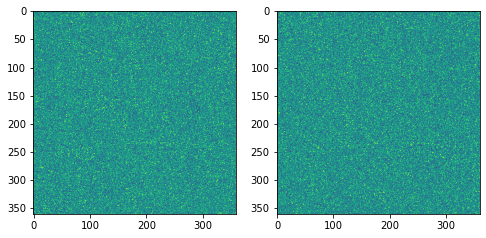

In [166]:

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(adaptive_resize(data['H1']['spectrogram'][:, :, None], 360, np.mean).clip(0, 4.0))
plt.subplot(1, 2, 2)
plt.imshow(adaptive_resize(data['L1']['spectrogram'][:, :, None], 360, np.mean).clip(0, 4.0))
plt.show()

In [128]:
from scipy.signal import istft

In [44]:
for _ in range(100):
    _, waveform = istft(test_signal, nperseg=2)

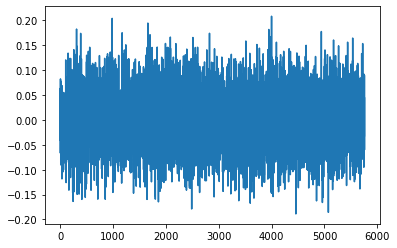

In [51]:
plt.plot(waveform*1e23)

In [36]:
# trns = A.Compose([ToSpectrogram(), AdaptiveResize(8)])
# sft = trns(image=sft['H1'][:, :, None])['image']
# plt.imshow(sft)

# Model

In [18]:
# from replknet import create_RepLKNet31B, create_RepLKNet31L
# from kuma_utils.torch.utils import fit_state_dict
# import torch

In [27]:
# model = create_RepLKNet31B(in_chans=2, num_classes=1)

In [25]:
# checkpoint = torch.load('input/RepLKNet-31B_ImageNet-22K-to-1K_384.pth')
# fit_state_dict(checkpoint, model)
# model.load_state_dict(checkpoint, strict=False)

Size mismatch in stem.0.conv.weight: torch.Size([128, 3, 3, 3]) -> torch.Size([128, 2, 3, 3])
Size mismatch in head.weight: torch.Size([1000, 1024]) -> torch.Size([1, 1024])
Size mismatch in head.bias: torch.Size([1000]) -> torch.Size([1])
